# Select contour for calculating cross-slope transports

This script:
1. Finds a depth contour on the centre of the t-grid - 
   e.g. all points closest to Antarctica with depth <= 1000m. 
    The points need to be connected.
2. Manually cleans up any messy closed loops etc in contour.
3. Separates into masks for x and y transport, with +/- to account for direction 
    away from / towards Antarctic region. Note the transports are on the centre 
    edges of the t-cells away from Antarctica compared with the isobath mask 
    definition (and the edges can be deeper than 1000m, because I used the centre 
    of the grid to define the isobath).


In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean as cm
import glob
import matplotlib.colors as col
# need to install opencv-python for this:
import cv2

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/home/156/wf4500/v45_wf4500/Project_panan/GH/Panan_HT_ASC/figs/'

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43775,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:34077,Total threads: 4
Dashboard: /proxy/32901/status,Memory: 143.87 GiB
Nanny: tcp://127.0.0.1:45117,


In [3]:
session = cc.database.create_session()

In [4]:
exp = 'panant-01-zstar-ACCESSyr2'

lat_range = slice(-90,-59)

contour_depth = 1000

## Import bathymetry and find depth contours

In [5]:
yh = cc.querying.getvar(exp,'yh',session,n=1) #cells centres
yh = yh.sel(yh=lat_range)
xq = cc.querying.getvar(exp,'xq',session,n=1)
xh = cc.querying.getvar(exp,'xh',session,n=1)  #cells centres
yq = cc.querying.getvar(exp,'yq',session,n=1)

ht = cc.querying.getvar(exp,'deptho',session,n=1) 
ht = ht.sel(yh=lat_range)
# fill in land with zeros:
ht = ht.fillna(0)

temp_mask = np.copy(ht)
temp_mask[np.where(ht>contour_depth)] = 0
temp_mask[np.where(ht<=contour_depth)] = 1

In [6]:
# this spreads the isobath contour so all points are connected adjacently (not just 
# diagonally):
kernel = np.ones((3,3),np.uint8)
contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask

# start at western edge of domain, at y point closest to correct depth contour:
contour_mask = np.zeros_like(ht)
if contour_depth == 1000:
    # pick most southerly contour:
    contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][0]
else:
    # pick most northerly contour:
    contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][-1]
contour_mask[contour_lat_index_start,0] = 1

In [7]:
######### Currently working in the cell below ####
#im slowly checking every part of the domain to make sure everything is right

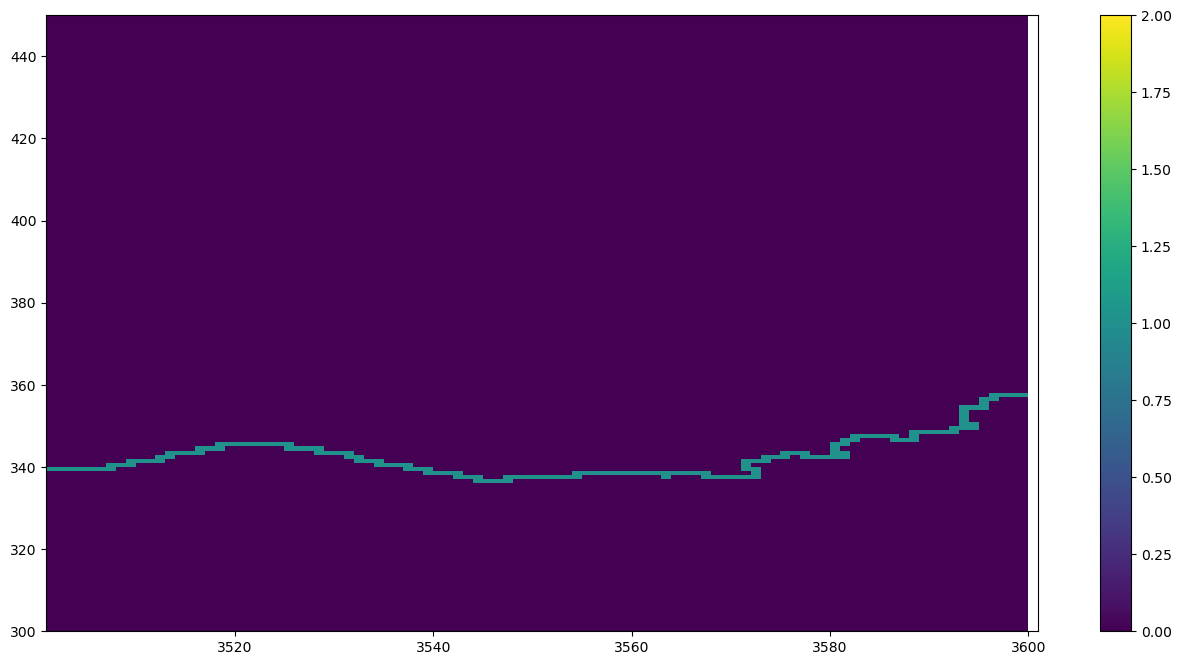

In [8]:
# in case you want to check what contour_mask0 looks like, e.g. is it continuous around Antarctica?
xext=100
xinit=3501

plt.figure(1,figsize=(16,8))
plt.pcolormesh(contour_mask0)
plt.colorbar()
plt.clim((0,2))
plt.xlim((xinit,xinit+xext))
plt.ylim((300,450));

In [ ]:
# Report of what i've seen for the 1km isobath
#    Weird loop around the xindex 240. Should we fix it?
#    Weird loop around the xindex 2170. Should we fix it?
#    Weird isobath connection in a channel close to the xindex 2235. Should we fix it?
#    Weird isobath connection in isobaths close to the xindex 2275. top of the AP Should we fix it?
#    Weird isobath loop close to the xindex 2280,yindex ~420. middle of the AP Should we fix it?
#    Weird isobath loop close to the xindex 2280,yindex ~420. middle of the AP Should we fix it?
#    Weird isobath loop close to the xindex 2720,yindex ~250. middle of the AP Should we fix it?
#    Weird isobath loop close to the xindex 2890,yindex ~270. middle of the AP Should we fix it?
#    Weird isobath loop close to the xindex 3070,yindex ~270. middle of the AP Should we fix it?

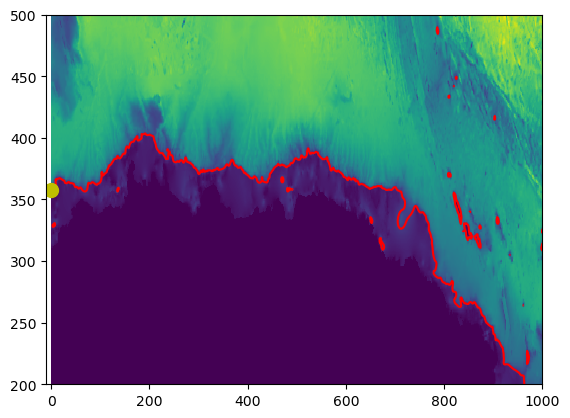

In [10]:
# plot to make sure contour_lat_index_start (yellow dot) is on the correct contour:

plt.pcolormesh(ht)
plt.contour(ht,[contour_depth],colors='r')
plt.xlim((-10,1000))
plt.ylim((200,500))
plt.plot(0,contour_lat_index_start,'yo',markersize=10)

## Select out only the contour we want

In [11]:
# loop through to find adjacent point closest to isobath depth (not inc previous point):
last_index_i = 0
last_index_j = contour_lat_index_start
count = 0
while last_index_i<ht.shape[1]-1:
    #print(last_index_i)
    # first time don't go backwards:
    if last_index_i == 0:
        points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
            0,
            contour_mask0[last_index_j+1,last_index_i],
            contour_mask0[last_index_j-1,last_index_i]])
    else:
        points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
            contour_mask0[last_index_j,last_index_i-1],
            contour_mask0[last_index_j+1,last_index_i],
            contour_mask0[last_index_j-1,last_index_i]])

    new_loc = np.where(points_to_compare==1)[0]

    # this gives each point along contour a unique index number:
    if len(new_loc)==0:
        contour_mask[last_index_j,last_index_i] = 0
        contour_mask0[last_index_j,last_index_i] = 0
        #contour_mask0[contour_mask==count] = 0
        #print('j'+str(last_index_j)+'i'+str(last_index_i))
        count = count - 1
        last_index_i = np.where(contour_mask==count+1)[1]
        last_index_j = np.where(contour_mask==count+1)[0]
        continue
    elif len(new_loc)>0:
        if new_loc[0] == 0:
            new_index_i = last_index_i+1
            new_index_j = last_index_j
        elif new_loc[0] == 1:
            new_index_i = last_index_i-1
            new_index_j = last_index_j
        elif new_loc[0] == 2:
            new_index_i = last_index_i
            new_index_j = last_index_j+1
        elif new_loc[0] == 3:
            new_index_i = last_index_i
            new_index_j = last_index_j-1
        contour_mask[new_index_j,new_index_i] = count + 2
        contour_mask0[last_index_j,last_index_i] = 2
        last_index_j = new_index_j
        last_index_i = new_index_i
        count += 1


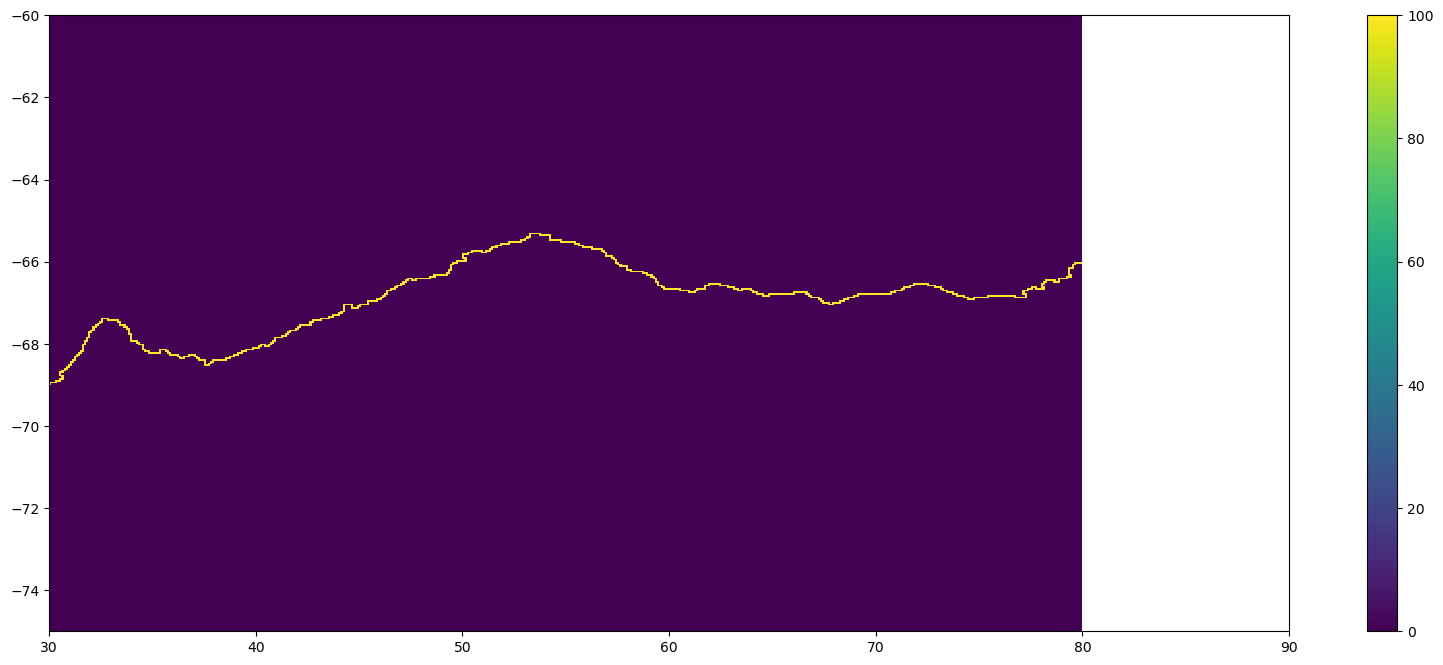

In [39]:
# check what contour_mask looks like, is it continuous around Antarctica? YES!
#between -280 and -200: yes
#between -220 and -140: yes
#between -140 and -50: yes
#between -50 and 30: yes
#between 30 and 90: yes

plt.figure(1,figsize=(20,8))
plt.pcolormesh(xh,yh,contour_mask)
plt.colorbar()
plt.clim((0,100))
plt.xlim((30,90))
plt.ylim((-75,-60));

## Manually edit out any extraneous loops that won't contribute to the cross-slope transport anyway

#### Visual Evaluation

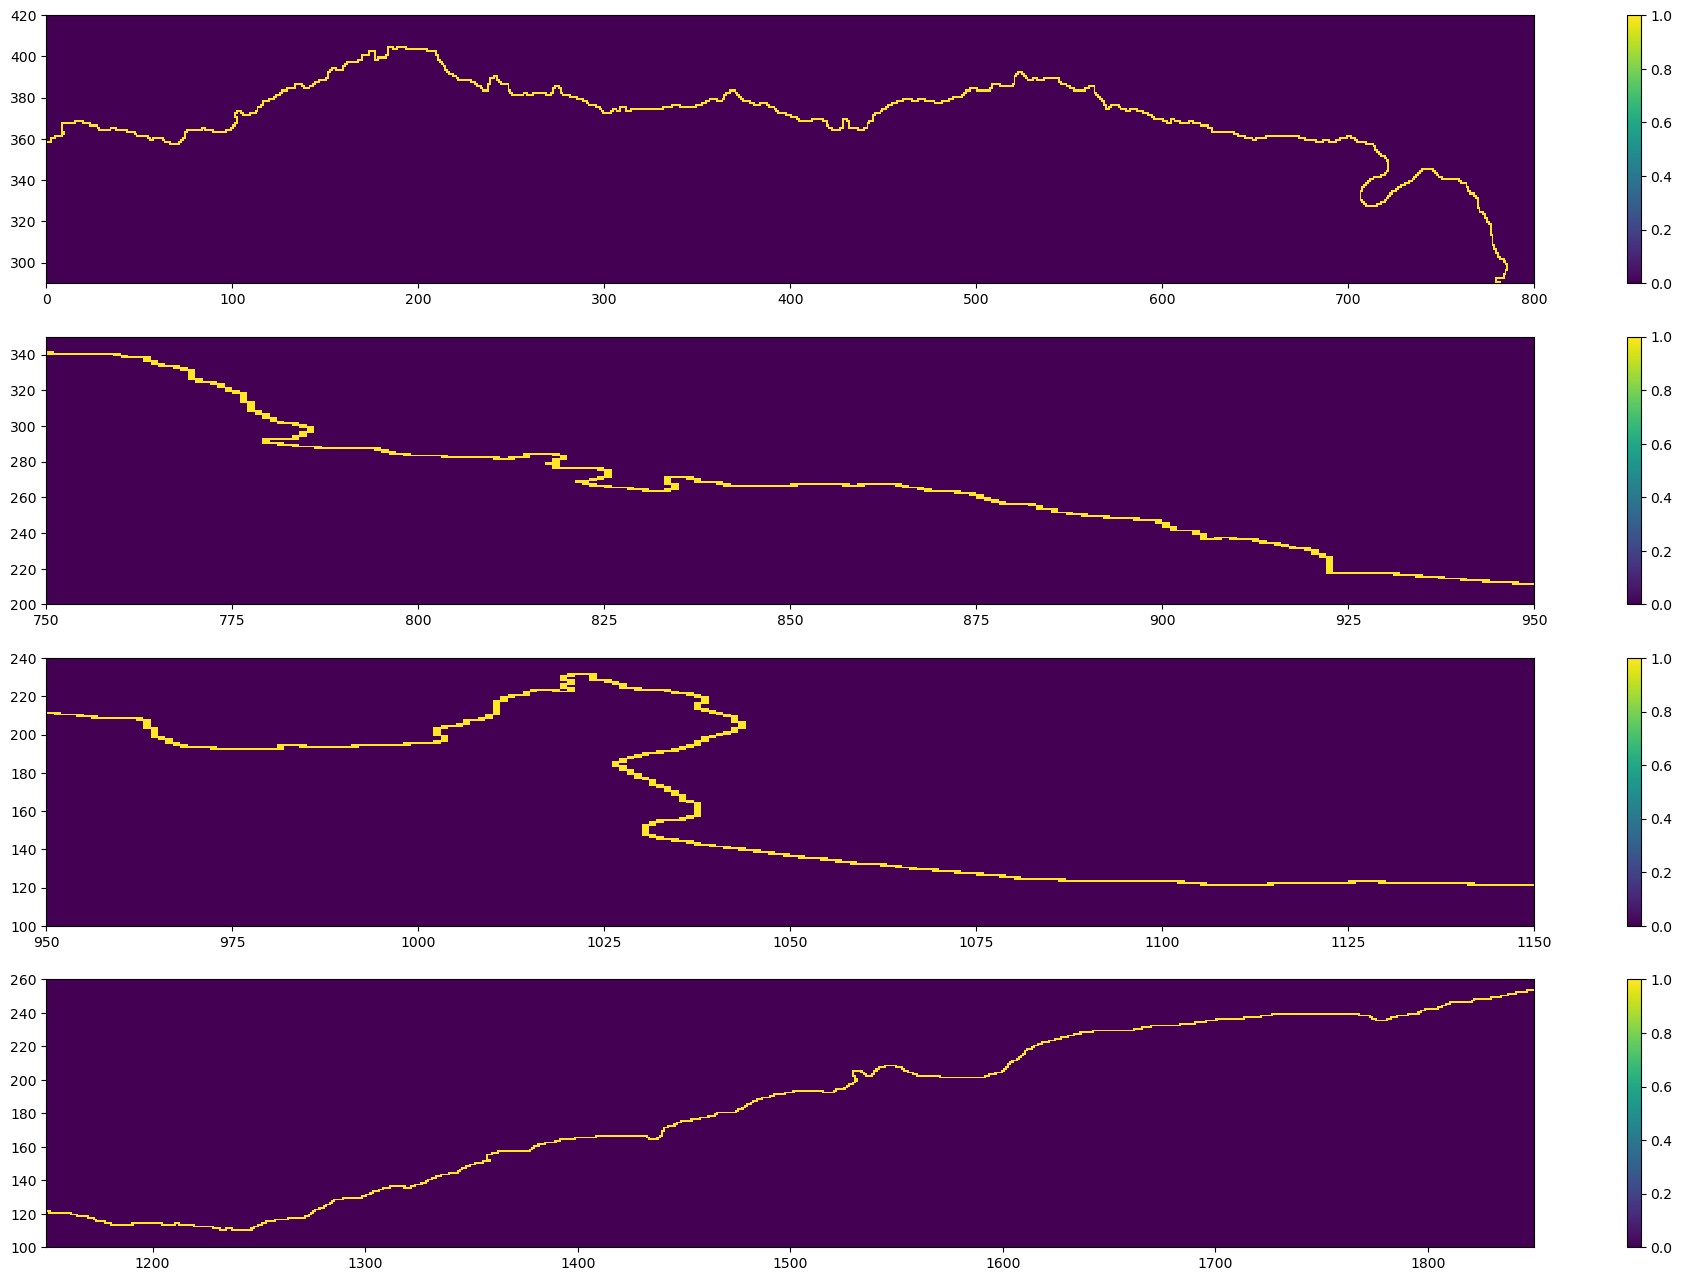

In [107]:
plt.figure(1,figsize=(24,16))

plt.subplot(4,1,1) #Do we need to fix the loop in xind =100?
plt.pcolormesh(contour_mask)
plt.colorbar()
plt.clim((0,1))
plt.xlim((0,800))
plt.ylim(290,420);

plt.subplot(4,1,2) #Do we need to fix the loop in xind =775,820,825?
plt.pcolormesh(contour_mask)
plt.colorbar()
plt.clim((0,1))
plt.xlim((750,950))
plt.ylim(200,350);

plt.subplot(4,1,3) #Do we need to fix the loop in xind =1020?
plt.pcolormesh(contour_mask)
plt.colorbar()
plt.clim((0,1))
plt.xlim((950,1150))
plt.ylim(100,240);

plt.subplot(4,1,4) #Do we need to fix the loop in xind =1370?
plt.pcolormesh(contour_mask)
plt.colorbar()
plt.clim((0,1))
plt.xlim((1150,1850))
plt.ylim(100,260);

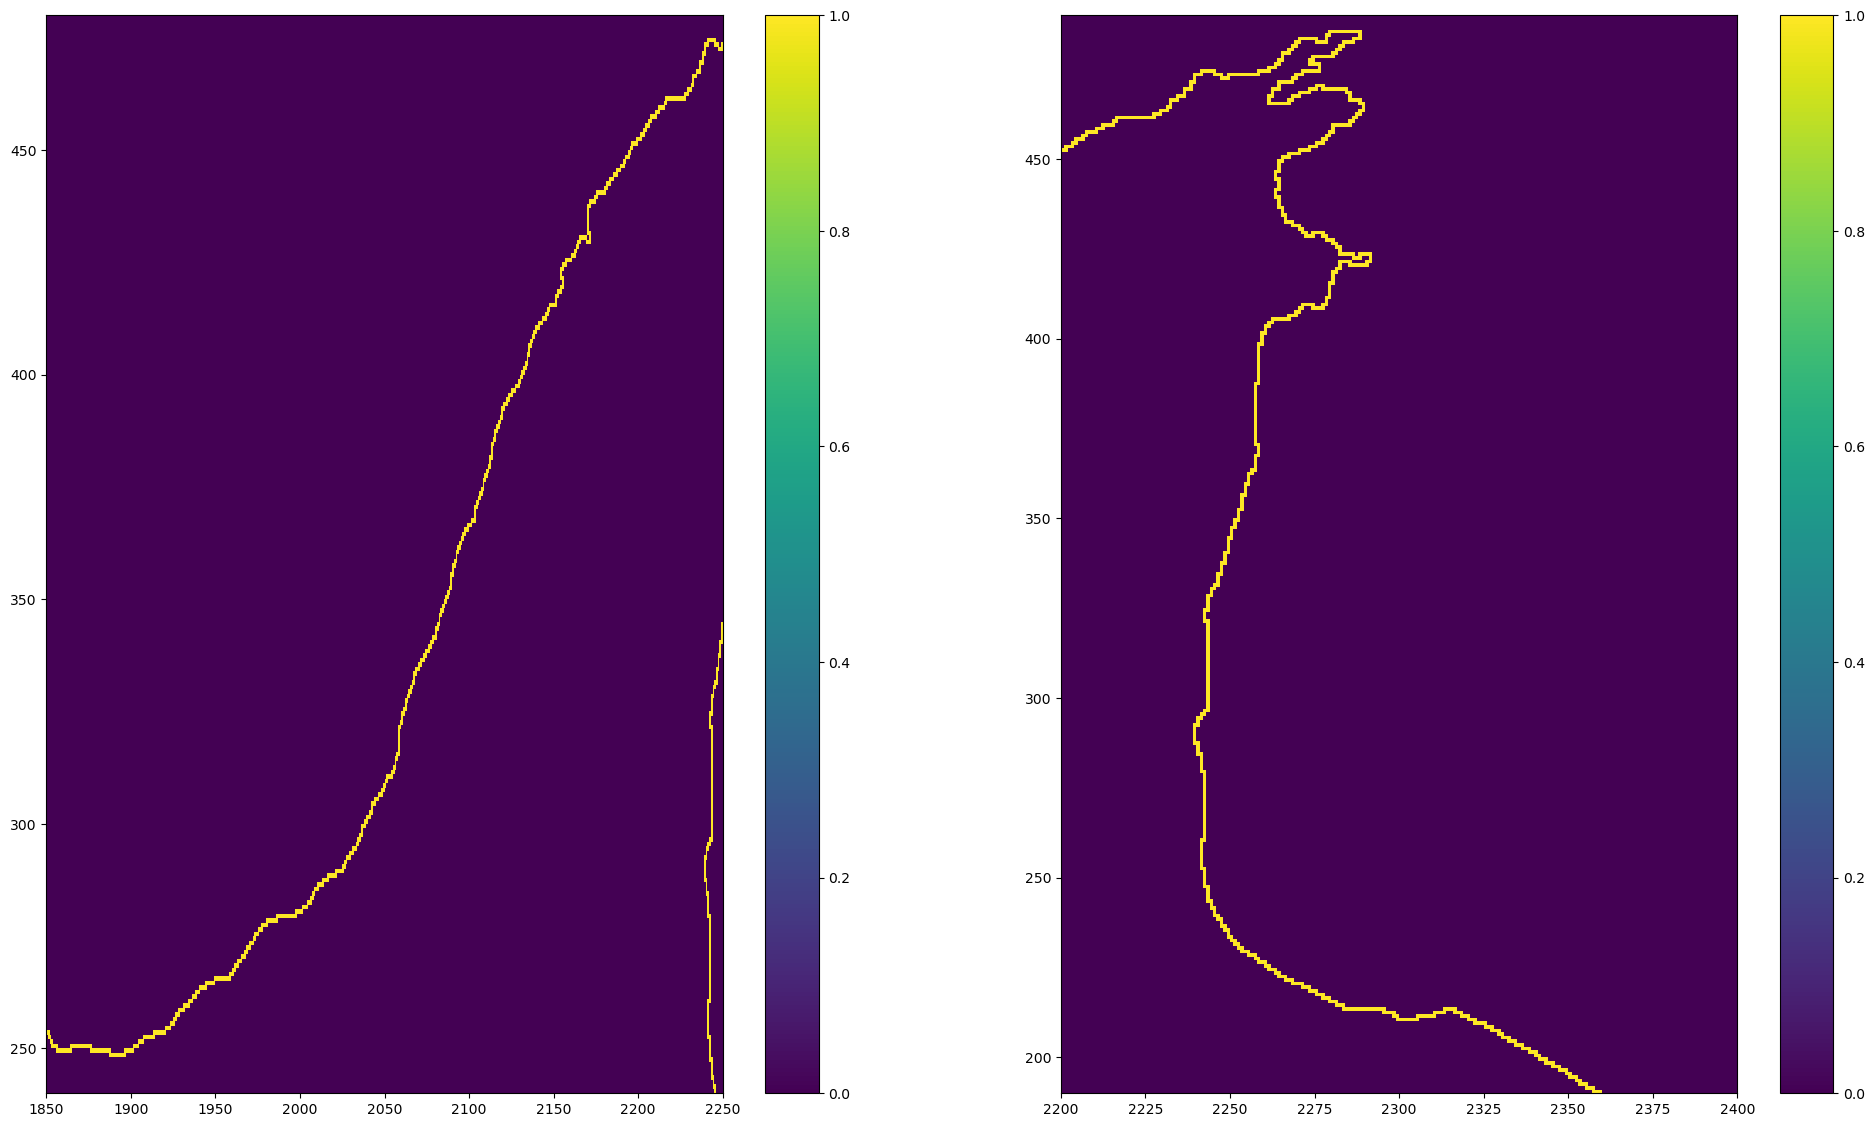

In [117]:
plt.figure(1,figsize=(24,14))

plt.subplot(1,2,1) #Do we need to fix the loop in xind xind~=2170, yind~=425?
plt.pcolormesh(contour_mask)
plt.colorbar()
plt.clim((0,1))
plt.xlim(1850,2250)
plt.ylim(240,480);

plt.subplot(1,2,2) #Do we need to fix the loop in (2275,480) and  (2290,420)?
plt.pcolormesh(contour_mask)
plt.colorbar()
plt.clim((0,1))
plt.xlim(2200,2400)
plt.ylim(190,490);

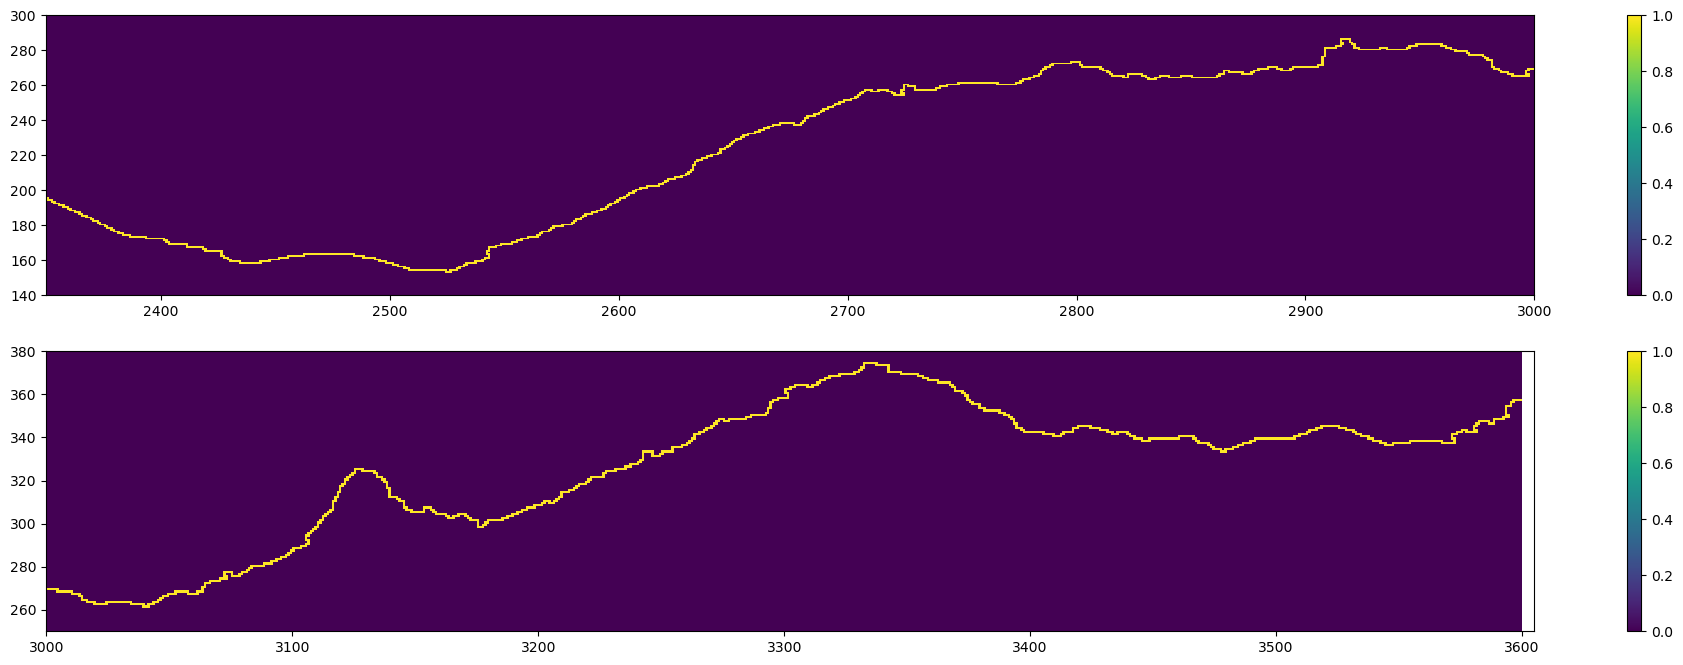

In [127]:
plt.figure(1,figsize=(24,8))

plt.subplot(2,1,1) 
plt.pcolormesh(contour_mask)
plt.colorbar()
plt.clim((0,1))
plt.xlim(2350,3000)
plt.ylim(140,300);

plt.subplot(2,1,2)
plt.pcolormesh(contour_mask)
plt.colorbar()
plt.clim((0,1))
plt.xlim(3000,3605)
plt.ylim(250,380);

#### Fixing loops

I need to discuss wih Adele which loops eed closing, So I will not run the line below

In [128]:
# # just need to remove loops, not double thickness contour or small indents:


# # for panan-01 only
# if contour_depth ==1000:
#     contour_mask[(contour_mask>1656)&(contour_mask<1662)] = 0
#     contour_mask[223,1019] = 1657
#     contour_mask[contour_mask>1661] -= 4
#     contour_mask[(contour_mask>3374)&(contour_mask<3380)] = 0
#     contour_mask[430,2170] = 3375
#     contour_mask[contour_mask>3375] -= 4
    
# if contour_depth ==1500:
#     contour_mask[(contour_mask>632)&(contour_mask<639)] = 0
#     contour_mask[contour_mask>=639] -= 6
    
# if contour_depth ==2500:
#     contour_mask[(contour_mask>895)&(contour_mask<901)] = 0
#     contour_mask[380,453] = 896
#     contour_mask[contour_mask>=901] -= 4
#     contour_mask[(contour_mask>1085)&(contour_mask<1102)] = 0
#     contour_mask[contour_mask>=1102] -= 16
#     contour_mask[(contour_mask>1173)&(contour_mask<1180)] = 0
#     contour_mask[contour_mask>=1180] -= 6

## Create mask to separate points above contour from points below contour

In [142]:
contour_mask_numbered = contour_mask

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1,0] = -100

# from top left:
for ii in range(len(xh)-1):
    for jj in range(len(yh))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj-1,ii+1] == 0:
                contour_masked_above[jj-1,ii+1] = -100
# from top right:
for ii in range(len(xh))[::-1][:-1]:
    for jj in range(len(yh))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj-1,ii-1] == 0:
                contour_masked_above[jj-1,ii-1] = -100
# from bottom right:
for ii in range(len(xh))[::-1][:-1]:
    for jj in range(len(yh)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj+1,ii-1] == 0:
                contour_masked_above[jj+1,ii-1] = -100
# from bottom left:
for ii in range(len(xh)-1):
    for jj in range(len(yh)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj+1,ii+1] == 0:
                contour_masked_above[jj+1,ii+1] = -100


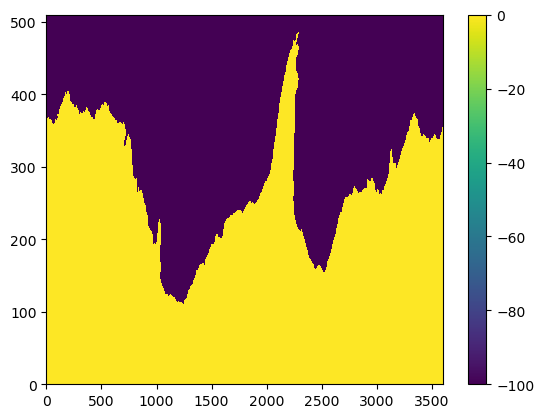

In [145]:
plt.pcolormesh(contour_masked_above,vmin=-100,vmax=0);plt.colorbar()

## Create masks for x and y transport calculations (i.e. determine if positive u and v will be into or out of contour)

In [146]:
# separate out points on isobath that will correspond to zonal or meridional transport
# across contour (i.e. depending on localshape of contour):

# make masks to multiply x and y transports at correct places:
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)
# make halos:
contour_masked_above_halo = np.zeros((contour_masked_above.shape[0],
    contour_masked_above.shape[1]+2))
contour_masked_above_halo[:,0] = contour_masked_above[:,-1]
contour_masked_above_halo[:,1:-1] = contour_masked_above
contour_masked_above_halo[:,-1] = contour_masked_above[:,0]

new_number_count = 1
for mask_loc in range(1,int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1,index_i]==0) and (contour_masked_above[index_j-1,index_i]!=0):
        mask_y_transport[index_j,index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j,index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1,index_i]==0) and (contour_masked_above[index_j+1,index_i]!=0):
        mask_y_transport[index_j-1,index_i] = 1
        mask_y_transport_numbered[index_j-1,index_i] = new_number_count
        new_number_count += 1
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j,index_i+2]==0) and (contour_masked_above_halo[index_j,index_i]!=0):
        mask_x_transport[index_j,index_i] = -1
        mask_x_transport_numbered[index_j,index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j,index_i]==0) and (contour_masked_above_halo[index_j,index_i+2]!=0):
        mask_x_transport[index_j,index_i-1] = 1
        mask_x_transport_numbered[index_j,index_i-1] = new_number_count
        new_number_count += 1


## Save

In [148]:
import os

In [153]:
save_dir =  '/home/156/wf4500/v45_wf4500/Project_panan/GH/Panan_HT_ASC/contours/'
os.makedirs(save_dir,exist_ok='True')
outfile = os.path.join(save_dir,'Antarctic_slope_contour_Panan01_'+str(contour_depth)+'m.npz')

np.savez(outfile,contour_mask_numbered = contour_mask_numbered, 
    contour_masked_above = contour_masked_above, contour_depth = contour_depth,
    xh = xh, yh = yh,
    mask_y_transport = mask_y_transport, mask_x_transport = mask_x_transport,
    mask_y_transport_numbered = mask_y_transport_numbered, 
    mask_x_transport_numbered = mask_x_transport_numbered)

## Compare different contours from saved data

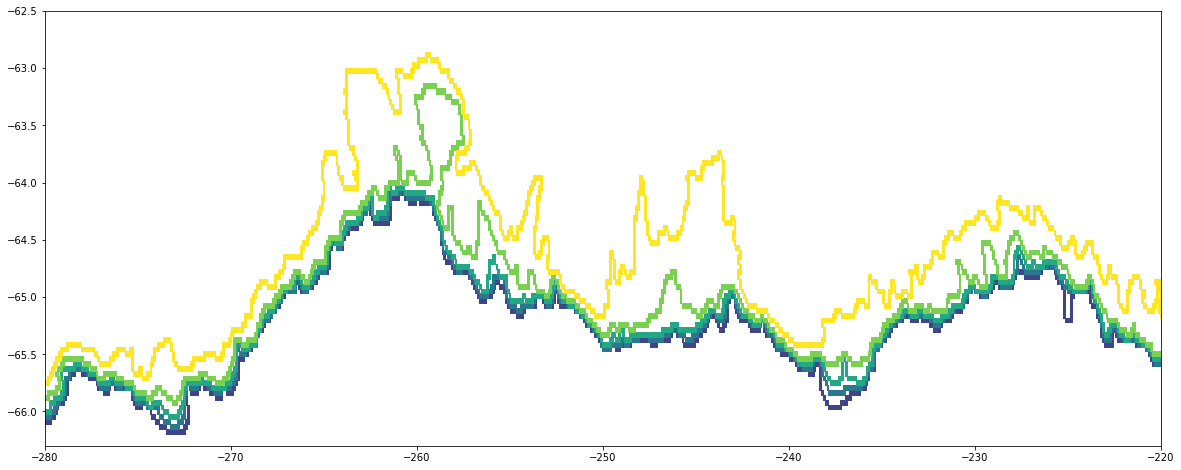

In [386]:
# note that this plot is only approximate, it's not using the exact tracer/velocity grids for the different x and y isobath mask components

ht = cc.querying.getvar(exp,'ht',session,n=1)
ht = ht.sel(yt_ocean=lat_range)

plt.figure(3,figsize=(20,8))

# get isobath data:
isobath_depth = 650
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']
combined_contour_mask = np.where((mask_y_transport_numbered>0)|(mask_x_transport_numbered>0),1,0)
#plot:
plt.pcolormesh(xt_ocean,yt_ocean,np.ma.masked_where(combined_contour_mask<1,combined_contour_mask))
plt.clim((0,5))

# get isobath data:
isobath_depth = 800
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']
combined_contour_mask = np.where((mask_y_transport_numbered>0)|(mask_x_transport_numbered>0),2,0)
#plot:
plt.pcolormesh(xt_ocean,yt_ocean,np.ma.masked_where(combined_contour_mask<1,combined_contour_mask))
plt.clim((0,5))

# get isobath data:
isobath_depth = 1000
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']
combined_contour_mask = np.where((mask_y_transport_numbered>0)|(mask_x_transport_numbered>0),3,0)
#plot:
plt.pcolormesh(xt_ocean,yt_ocean,np.ma.masked_where(combined_contour_mask<1,combined_contour_mask))
plt.clim((0,5))

# get isobath data:
isobath_depth = 1500
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']
combined_contour_mask = np.where((mask_y_transport_numbered>0)|(mask_x_transport_numbered>0),4,0)
#plot:
plt.pcolormesh(xt_ocean,yt_ocean,np.ma.masked_where(combined_contour_mask<1,combined_contour_mask))
plt.clim((0,5))

# get isobath data:
isobath_depth = 2500
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']
combined_contour_mask = np.where((mask_y_transport_numbered>0)|(mask_x_transport_numbered>0),5,0)
#plot:
plt.pcolormesh(xt_ocean,yt_ocean,np.ma.masked_where(combined_contour_mask<1,combined_contour_mask))
plt.clim((0,5))

plt.xlim((-280,-220))
plt.ylim((-66.3,-62.5));